# Simple PZ Training Set Creation

Author: Melissa Graham

Date last verified to run: Wed Jan 4

RSP recommended image version: Weekly 2022_40

Container size: large

> **Warning:** The query in Section 3.3 takes ~15 minutes to execute.


## 1. Introduction

Some types of photometric redshift estimators requre a training set of galaxies with "known" (spectroscopic) redshifts.

In this notebook, we use the DC2 `TruthSummary` table to create a training set of galaxies in a small area of the DC2 region with "known" redshifts and _ugrizy_ photometry with observed apparent magnitude errors that represent the 10-year depth of the wide-fast-deep area.

File output: `simple_pz_training_set.txt`.

### 1.1. Import packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas
from lsst.rsp import get_tap_service, retrieve_query

### 1.2. Define parameters

In [2]:
pandas.set_option('display.max_rows', 200)
%matplotlib inline
service = get_tap_service()

In [3]:
plot_filter_labels = ['u', 'g', 'r', 'i', 'z', 'y']
plot_filter_colors = {'u': '#56b4e9', 'g': '#008060', 'r': '#ff4000',
                      'i': '#850000', 'z': '#6600cc', 'y': '#000000'}
plot_filter_symbols = {'u': 'o', 'g': '^', 'r': 'v', 'i': 's', 'z': '*', 'y': 'p'}

## 2. Obtain a couple million true galaxies

Retrieve the RA, Declination, true redshift, and true fluxes (without Milky Way extinction; i.e., dereddened) from the `TruthSummary` table.

This query takes about a minute.

In [4]:
%%time
query = "SELECT ra, dec, redshift, "\
        "flux_u_noMW, flux_g_noMW, flux_r_noMW, flux_i_noMW, flux_z_noMW, flux_y_noMW "\
        "FROM dp02_dc2_catalogs.TruthSummary "\
        "WHERE CONTAINS(POINT('ICRS', ra, dec), CIRCLE('ICRS', 54.0, -30.5, 0.6)) = 1 "\
        "AND truth_type = 1"
print(query)
print(' ')
results = service.search(query).to_table().to_pandas()
print('len(results) = ', len(results))

SELECT ra, dec, redshift, flux_u_noMW, flux_g_noMW, flux_r_noMW, flux_i_noMW, flux_z_noMW, flux_y_noMW FROM dp02_dc2_catalogs.TruthSummary WHERE CONTAINS(POINT('ICRS', ra, dec), CIRCLE('ICRS', 54.0, -30.5, 0.6)) = 1 AND truth_type = 1
 
len(results) =  2437615
CPU times: user 58.2 s, sys: 965 ms, total: 59.2 s
Wall time: 1min 11s


Show the true redshift distribution and the on-sky spatial distribution.

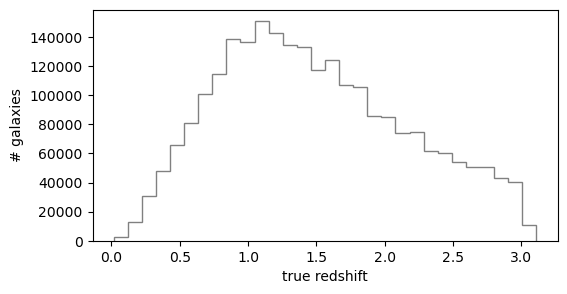

In [5]:
fig = plt.figure(figsize=(6, 3))
plt.hist(results['redshift'], bins=30, histtype='step', color='grey')
plt.xlabel('true redshift')
plt.ylabel('# galaxies')
plt.show()

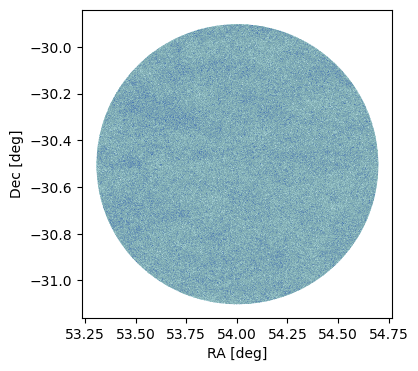

In [6]:
fig = plt.figure(figsize=(4, 4))
plt.plot(results['ra'], results['dec'], '.', ms=1, alpha=0.02, mew=0)
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
plt.show()

Convert true fluxes (nJy) to true AB magnitudes and show the distribution by filter.

In [7]:
for f, filt in enumerate(plot_filter_labels):
    results['mag_'+filt+'_noMW'] = -2.5 * np.log10(results['flux_'+filt+'_noMW']) + 31.4

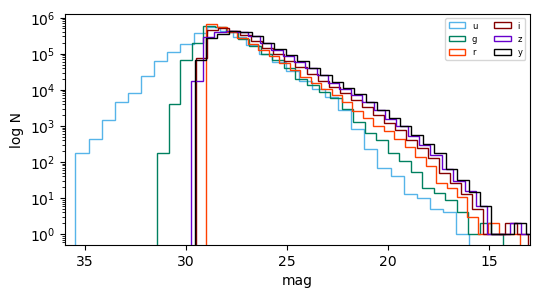

In [8]:
fig = plt.figure(figsize=(6, 3))
for f, filt in enumerate(plot_filter_labels):
    plt.hist(results['mag_'+filt+'_noMW'], bins=30, histtype='step', 
             log=True, color=plot_filter_colors[filt], label=filt)
plt.legend(loc='upper right', fontsize=6, ncol=2)
plt.xlim([36, 13])
plt.xlabel('mag')
plt.ylabel('log N')
plt.show()

### 2.1. Create simulated observed photometry

Use the 10-year depths ($5\sigma$ limiting magnitudes) for the LSST wide-fast-deep survey from <a href="https://ui.adsabs.harvard.edu/abs/2019ApJ...873..111I/abstract">Ivezić et al. (2019)</a> to calculate magnitude uncertaintites. 

The photometric error, $\sigma_{\rm rand}$, is given in Section 3.2.1 of Ivezić et al. (2019):

$$ \sigma_{\rm rand}^2 = (0.04 − \gamma)x + \gamma x^2 $$

where $ x = 10^{0.4(m - m_5)}$, $m_5$ is the $5\sigma$ limiting magnitude, $m$ is the magnitude of a galaxy, and for the LSST optical filters the values for $\gamma$ (which sets the impact of, e.g., sky brightness) are 0.037, 0.038, 0.039, 0.039, 0.04, and 0.04 for filters _ugrizy_, respectively.

Apply an uncertainty floor of 0.005. 

Any galaxy with a simulated uncertainty >0.2 mag is of too poor photometric quality to contribute to the training set, so the value of `mag_f_noMW_err` is reset to `NaN` and this galaxy is not used.

In [9]:
m5 = [26.09, 27.38, 27.53, 26.83, 26.06, 24.86]
gamma = [0.037, 0.038, 0.039, 0.039, 0.04, 0.04]

In [10]:
for f, filt in enumerate(plot_filter_labels):
    temp = np.power(10, 0.4*(results['mag_'+filt+'_noMW'] - m5[f]))
    results['mag_'+filt+'_noMW_err'] = np.sqrt( (0.04-gamma[f])*temp + (gamma[f]*temp**2) )
    del temp
    
    tx = np.where(results.loc[:, 'mag_'+filt+'_noMW_err'] < 0.005)[0]
    results.loc[tx, 'mag_'+filt+'_noMW_err'] = 0.005
    del tx
    
    tx = np.where(results.loc[:, 'mag_'+filt+'_noMW_err'] > 0.2)[0]
    results.loc[tx, 'mag_'+filt+'_noMW_err'] = float('NaN')
    del tx

To generate observed apparent magnitudes, a random value drawn from a normal distribution with a standard deviation equal to the photometric error for each galaxy is added to the true catalog magnitude.

At the same time, ensure that all galaxies with photometric errors of `NaN` also have observed magnitudes of `NaN`.

In [11]:
for f, filt in enumerate(plot_filter_labels):
    results['mag_'+filt+'_noMW_obs'] = results['mag_'+filt+'_noMW'] + \
                                       (np.random.normal(size=len(results)) * \
                                        results['mag_'+filt+'_noMW_err'])
    
    tx = np.where(np.isnan(results.loc[:, 'mag_'+filt+'_noMW_err']))[0]
    results.loc[tx, 'mag_'+filt+'_noMW_obs'] = float('NaN')
    del tx

### 2.2. Apply detection limits to create training set

Apply detection limits by setting the observed apparent magnitudes of any galaxy fainter than the 5-sigma limiting magnitude (10-year depth), or brighter than 17th magnitude in any filter (the saturation limit for LSST will be ~16 mag), to `NaN`.

In [12]:
for f, filt in enumerate(plot_filter_labels):
    tx = np.where(results.loc[:, 'mag_'+filt+'_noMW_obs'] > m5[f])[0]
    results.loc[tx, 'mag_'+filt+'_noMW_obs'] = float('NaN')
    del tx

    tx = np.where(results.loc[:, 'mag_'+filt+'_noMW_obs'] < 17.0)[0]
    results.loc[tx, 'mag_'+filt+'_noMW_obs'] = float('NaN')
    del tx

Print the fraction of the original set of galaxies that remain in the training set.

In [13]:
for f, filt in enumerate(plot_filter_labels):
    tx = np.where(np.isfinite(results.loc[:, 'mag_'+filt+'_noMW_obs']))[0]
    print('%1s %6i %8i %5.2f' % (filt, len(tx), len(results), float(len(tx))/float(len(results))))
    del tx

u 168065  2437615  0.07
g 616829  2437615  0.25
r 848805  2437615  0.35
i 642352  2437615  0.26
z 446793  2437615  0.18
y 217632  2437615  0.09


### 2.3. Print to file

Print the true galaxy to the file of all training set galaxies if it was "detected" (based on the simulated observed apparent magnitudes) in all four filters _griz_.

This takes about 30 seconds.

In [14]:
%%time

tx = np.where(np.isfinite(results.loc[:, 'mag_g_noMW_obs'])
              & np.isfinite(results.loc[:, 'mag_r_noMW_obs'])
              & np.isfinite(results.loc[:, 'mag_i_noMW_obs'])
              & np.isfinite(results.loc[:, 'mag_z_noMW_obs']))[0]
print('number detected in griz = ', len(tx))
print(' ')

fout = open('simple_pz_training_set.txt', 'w')
for x in tx:
    fout.write('%8.6f %10.6f %7.5f %7.4f %7.4f %7.4f %7.4f %7.4f %7.4f %7.4f %7.4f %7.4f %7.4f %7.4f %7.4f \n' % 
               (results.loc[x, 'ra'], results.loc[x, 'dec'], 
                results.loc[x, 'redshift'],
                results.loc[x, 'mag_u_noMW_obs'], results.loc[x, 'mag_g_noMW_obs'],
                results.loc[x, 'mag_r_noMW_obs'], results.loc[x, 'mag_i_noMW_obs'],
                results.loc[x, 'mag_z_noMW_obs'], results.loc[x, 'mag_y_noMW_obs'],
                results.loc[x, 'mag_u_noMW_err'], results.loc[x, 'mag_g_noMW_err'],
                results.loc[x, 'mag_r_noMW_err'], results.loc[x, 'mag_i_noMW_err'],
                results.loc[x, 'mag_z_noMW_err'], results.loc[x, 'mag_y_noMW_err']))
fout.close()
del tx

number detected in griz =  367131
 
CPU times: user 29.9 s, sys: 31.3 ms, total: 29.9 s
Wall time: 30 s


## 3. Explore training set with plots

To better understand the contents of the training set, make a few plots of the magnitude and redshift distributions.

### 3.1. Review the magnitude distributions of the training set

Compare the distribution of original true apparent magnitudes (wide transparent lines) to the distribution of simulated observed apparent magnitudes of galaxies that would be detected (narrow opaque lines).

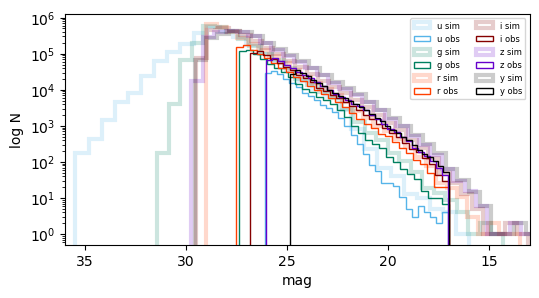

In [15]:
fig = plt.figure(figsize=(6, 3))
for f, filt in enumerate(plot_filter_labels):
    plt.hist(results['mag_'+filt+'_noMW'], bins=30, histtype='step', log=True, 
             lw=3, alpha=0.2, color=plot_filter_colors[filt], label=filt+' sim')
    plt.hist(results['mag_'+filt+'_noMW_obs'], bins=30, histtype='step', log=True, 
             lw=1, alpha=1, color=plot_filter_colors[filt], label=filt+' obs')
plt.legend(loc='upper right', fontsize=6, ncol=2)
plt.xlim([36, 13])
plt.xlabel('mag')
plt.ylabel('log N')
plt.show()

### 3.2. Review the redshift distribution of the training set

It is desirable for the training set to have a redshift distribution that is representative of the `Objects` catalog (i.e., the set of galaxies for which photometric redshifts are to be calculated).

The DC2 simulation contained many faint galaxies, and the plot below shows how removing them changes the redshift distribution of the training set compared to what was originally retrieved from the `TruthSummary` table.

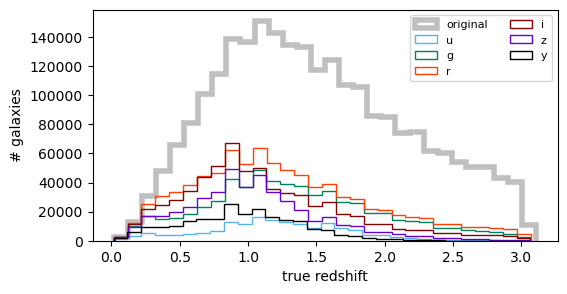

In [16]:
fig = plt.figure(figsize=(6, 3))
plt.hist(results['redshift'], bins=30, histtype='step', lw=4, alpha=0.5,
         color='grey', label='original')
for f, filt in enumerate(plot_filter_labels):
    tx = np.where(np.isfinite(results.loc[:, 'mag_'+filt+'_noMW_obs']))[0]
    plt.hist(results.loc[tx, 'redshift'], bins=30, histtype='step', 
             color=plot_filter_colors[filt], label=filt)
    del tx
plt.xlabel('true redshift')
plt.ylabel('# galaxies')
plt.legend(loc='best', ncol=2, fontsize=8)
plt.show()

Above shows a number distribution, but below use `density = True` (probability density: each bin will display the bin's raw count divided by the total number of counts and the bin width, so that the area under the histogram integrates to 1).

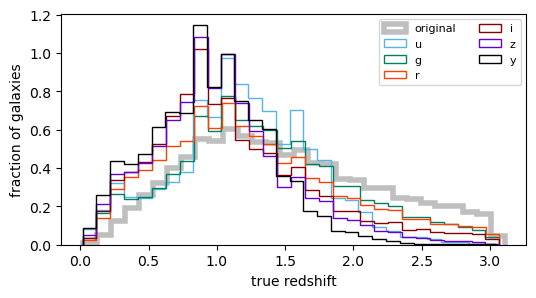

In [17]:
fig = plt.figure(figsize=(6, 3))
plt.hist(results['redshift'], bins=30, histtype='step', lw=4, alpha=0.5,
         color='grey', density=True, label='original')
for f, filt in enumerate(plot_filter_labels):
    tx = np.where(np.isfinite(results.loc[:, 'mag_'+filt+'_noMW_obs']))[0]
    plt.hist(results.loc[tx, 'redshift'], bins=30, histtype='step', density=True,
             color=plot_filter_colors[filt], label=filt)
    del tx
plt.xlabel('true redshift')
plt.ylabel('fraction of galaxies')
plt.legend(loc='best', ncol=2, fontsize=8)
plt.show()

As above, but comparing the original redshift distribution to that for all galaxies with simulated detected observed apparent magnitude in all four filters _griz_ (solid; matches what was printed to the training set file), and in any of those four (dashed).

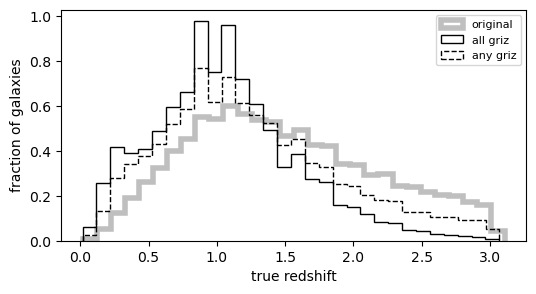

In [18]:
fig = plt.figure(figsize=(6, 3))

plt.hist(results['redshift'], bins=30, histtype='step', lw=4, alpha=0.5,
         color='grey', density=True, label='original')

tx = np.where(np.isfinite(results.loc[:, 'mag_g_noMW_obs'])
              & np.isfinite(results.loc[:, 'mag_r_noMW_obs'])
              & np.isfinite(results.loc[:, 'mag_i_noMW_obs'])
              & np.isfinite(results.loc[:, 'mag_z_noMW_obs']))[0]
plt.hist(results.loc[tx, 'redshift'], bins=30, histtype='step', density=True,
         color='black', label='all griz')
del tx

tx = np.where(np.isfinite(results.loc[:, 'mag_g_noMW_obs'])
              | np.isfinite(results.loc[:, 'mag_r_noMW_obs'])
              | np.isfinite(results.loc[:, 'mag_i_noMW_obs'])
              | np.isfinite(results.loc[:, 'mag_z_noMW_obs']))[0]
plt.hist(results.loc[tx, 'redshift'], bins=30, histtype='step', density=True,
         color='black', ls='dashed', label='any griz')
del tx

plt.xlabel('true redshift')
plt.ylabel('fraction of galaxies')
plt.legend(loc='best', fontsize=8)
plt.show()

### 3.3. Compare to the redshift distribution of matched objects

Retrieve the set of true galaxies in the same small area which were matched to an `Object`.

**This query takes about 15 minutes.**

In [19]:
%%time
query = "SELECT mt.id_truth_type, mt.match_objectId, ts.redshift, ts.truth_type, "\
        "obj.g_cModelFlux, obj.r_cModelFlux, obj.i_cModelFlux, obj.z_cModelFlux "\
        "FROM dp02_dc2_catalogs.MatchesTruth AS mt "\
        "JOIN dp02_dc2_catalogs.TruthSummary AS ts ON mt.id_truth_type = ts.id_truth_type "\
        "JOIN dp02_dc2_catalogs.Object AS obj ON mt.match_objectId = obj.objectId "\
        "WHERE CONTAINS(POINT('ICRS', ts.ra, ts.dec), CIRCLE('ICRS', 54.0, -30.5, 0.6)) = 1 "
print(query)
print(' ')
matched = service.search(query).to_table().to_pandas()
print(len(matched))
print(' ')

SELECT mt.id_truth_type, mt.match_objectId, ts.redshift, ts.truth_type, obj.g_cModelFlux, obj.r_cModelFlux, obj.i_cModelFlux, obj.z_cModelFlux FROM dp02_dc2_catalogs.MatchesTruth AS mt JOIN dp02_dc2_catalogs.TruthSummary AS ts ON mt.id_truth_type = ts.id_truth_type JOIN dp02_dc2_catalogs.Object AS obj ON mt.match_objectId = obj.objectId WHERE CONTAINS(POINT('ICRS', ts.ra, ts.dec), CIRCLE('ICRS', 54.0, -30.5, 0.6)) = 1 
 
559347
 
CPU times: user 12.5 s, sys: 231 ms, total: 12.8 s
Wall time: 14min 17s


<br>

Add the redshift distribution for all galaxies matched to the `Object` catalog and **"detected"** in the 6-year `deepCoadd` in all four filters _griz_ (red dotted).

**Note that below "detected" means "has a flux greater than `f5`, the flux corresponding to the 10-year 5-sigma limiting magnitude (`m5`)".** 

In [20]:
print(m5)
temp = np.asarray(m5, dtype='float')
f5 = np.zeros(6, dtype='float')
f5 = np.power(10, (temp - 31.4) / (-2.5))
print(f5)
del temp

[26.09, 27.38, 27.53, 26.83, 26.06, 24.86]
[133.0454418   40.55085354  35.31831698  67.29766563 136.77288256
 413.04750199]


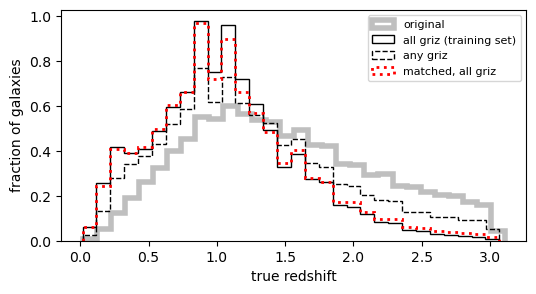

In [21]:
fig = plt.figure(figsize=(6, 3))

plt.hist(results['redshift'], bins=30, histtype='step', lw=4, alpha=0.5,
         color='grey', density=True, label='original')

tx = np.where(np.isfinite(results.loc[:, 'mag_g_noMW_obs'])
              & np.isfinite(results.loc[:, 'mag_r_noMW_obs'])
              & np.isfinite(results.loc[:, 'mag_i_noMW_obs'])
              & np.isfinite(results.loc[:, 'mag_z_noMW_obs']))[0]
plt.hist(results.loc[tx, 'redshift'], bins=30, histtype='step', density=True,
         color='black', label='all griz (training set)')
del tx

tx = np.where(np.isfinite(results.loc[:, 'mag_g_noMW_obs'])
              | np.isfinite(results.loc[:, 'mag_r_noMW_obs'])
              | np.isfinite(results.loc[:, 'mag_i_noMW_obs'])
              | np.isfinite(results.loc[:, 'mag_z_noMW_obs']))[0]
plt.hist(results.loc[tx, 'redshift'], bins=30, histtype='step', density=True,
         color='black', ls='dashed', label='any griz')
del tx

tx = np.where((matched.loc[:, 'truth_type'] == 1) 
              & (matched.loc[:, 'g_cModelFlux'] > f5[1]) 
              & (matched.loc[:, 'r_cModelFlux'] > f5[2]) 
              & (matched.loc[:, 'i_cModelFlux'] > f5[3]) 
              & (matched.loc[:, 'z_cModelFlux'] > f5[4]))[0]
plt.hist(matched.loc[tx, 'redshift'], bins=30, histtype='step', density=True,
         color='red', lw=2, ls='dotted', label='matched, all griz')
del tx

plt.xlabel('true redshift')
plt.ylabel('fraction of galaxies')
plt.legend(loc='best', fontsize=8)
plt.show()

Above we can see that the redshift distribution of the training set (solid black line) is pretty similar to the redshift distribution of detected objects (red dashed line) for which one would conceivably want to measure photometric redshifts for.

This means that -- with the exception of effects caused by cosmic variance -- the training set is "representative".

## 4. Quantify effect of cosmic variance

Do four similar queries using the same area as was used to make the training set, and compare the redshift distributions.

The difference between the four distributions demonstrates the effect of cosmic variance from using a small area on the sky to generate a training set.

Each query takes about a minute to execute.

In [22]:
%%time
query = "SELECT redshift, flux_g_noMW, flux_r_noMW, flux_i_noMW, flux_z_noMW "\
        "FROM dp02_dc2_catalogs.TruthSummary "\
        "WHERE CONTAINS(POINT('ICRS', ra, dec), CIRCLE('ICRS', 56.0, -30.5, 0.6)) = 1 "\
        "AND truth_type = 1"
temp1 = service.search(query).to_table().to_pandas()

CPU times: user 33.4 s, sys: 356 ms, total: 33.8 s
Wall time: 42.1 s


In [23]:
%%time
query = "SELECT redshift, flux_g_noMW, flux_r_noMW, flux_i_noMW, flux_z_noMW "\
        "FROM dp02_dc2_catalogs.TruthSummary "\
        "WHERE CONTAINS(POINT('ICRS', ra, dec), CIRCLE('ICRS', 67.0, -32.5, 0.6)) = 1 "\
        "AND truth_type = 1"
temp2 = service.search(query).to_table().to_pandas()

CPU times: user 33.5 s, sys: 391 ms, total: 33.9 s
Wall time: 42 s


In [24]:
%%time
query = "SELECT redshift, flux_g_noMW, flux_r_noMW, flux_i_noMW, flux_z_noMW "\
        "FROM dp02_dc2_catalogs.TruthSummary "\
        "WHERE CONTAINS(POINT('ICRS', ra, dec), CIRCLE('ICRS', 57.0, -37.5, 0.6)) = 1 "\
        "AND truth_type = 1"
temp3 = service.search(query).to_table().to_pandas()

CPU times: user 33.8 s, sys: 354 ms, total: 34.2 s
Wall time: 42.2 s


In [25]:
%%time
query = "SELECT redshift, flux_g_noMW, flux_r_noMW, flux_i_noMW, flux_z_noMW "\
        "FROM dp02_dc2_catalogs.TruthSummary "\
        "WHERE CONTAINS(POINT('ICRS', ra, dec), CIRCLE('ICRS', 63.0, -41.5, 0.6)) = 1 "\
        "AND truth_type = 1"
temp4 = service.search(query).to_table().to_pandas()

CPU times: user 33.4 s, sys: 327 ms, total: 33.7 s
Wall time: 42.1 s


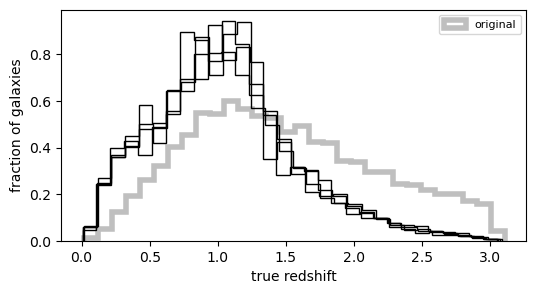

In [26]:
fig = plt.figure(figsize=(6, 3))

plt.hist(results['redshift'], bins=30, histtype='step', lw=4, alpha=0.5,
         color='grey', density=True, label='original')

tx = np.where((temp1.loc[:, 'flux_g_noMW'] > f5[1])
             & (temp1.loc[:, 'flux_r_noMW'] > f5[2])
             & (temp1.loc[:, 'flux_i_noMW'] > f5[3])
             & (temp1.loc[:, 'flux_z_noMW'] > f5[4]))[0]
plt.hist(temp1.loc[tx, 'redshift'], bins=30, histtype='step', density=True, color='black')
del tx

tx = np.where((temp2.loc[:, 'flux_g_noMW'] > f5[1])
             & (temp2.loc[:, 'flux_r_noMW'] > f5[2])
             & (temp2.loc[:, 'flux_i_noMW'] > f5[3])
             & (temp2.loc[:, 'flux_z_noMW'] > f5[4]))[0]
plt.hist(temp2.loc[tx, 'redshift'], bins=30, histtype='step', density=True, color='black')
del tx

tx = np.where((temp3.loc[:, 'flux_g_noMW'] > f5[1])
             & (temp3.loc[:, 'flux_r_noMW'] > f5[2])
             & (temp3.loc[:, 'flux_i_noMW'] > f5[3])
             & (temp3.loc[:, 'flux_z_noMW'] > f5[4]))[0]
plt.hist(temp3.loc[tx, 'redshift'], bins=30, histtype='step', density=True, color='black')
del tx

tx = np.where((temp4.loc[:, 'flux_g_noMW'] > f5[1])
             & (temp4.loc[:, 'flux_r_noMW'] > f5[2])
             & (temp4.loc[:, 'flux_i_noMW'] > f5[3])
             & (temp4.loc[:, 'flux_z_noMW'] > f5[4]))[0]
plt.hist(temp4.loc[tx, 'redshift'], bins=30, histtype='step', density=True, color='black')
del tx

plt.xlabel('true redshift')
plt.ylabel('fraction of galaxies')
plt.legend(loc='best', fontsize=8)
plt.show()

Above we can see that some redshift bins around z=1 have 20% more or less galaxies in them, due to large scale structure along the sightline. 

Any photo-z estimator that uses N(z) is going to have its results affected by the N(z) profile along the line-of-sight for the training set.